# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 1
&copy; 2021 Prof. Dr. Philipp Hennig & Jonathan Wenger

This sheet is **due on Monday, October 25, 2021 at 12noon sharp (i.e. before the start of the lecture).**

---

## Data Manipulation and Visualization

This first coding exercise will introduce you to some basic concepts of working with data. As a use case we will consider statistics of the ongoing COVID-19 pandemic from two different sources. You will download the data, extract and pre-process the subset we are interested in for downstream analysis and generate some basic visualizations. These will also answer some initial questions you might have about the data and generate new questions regarding estimation of the latent number of infections, the spread of the virus and its mortality.

The tasks will primarily serve as an introduction to `pandas`, a Python tool for data manipulation and basic analysis and `matplotlib` a framework for plotting.

<img src="https://blog.dask.org/images/split-apply-combine.png" alt="split-apply-combine" style="width: 600px;"/>

### Initial Setup

For these homework exercises we expect basic familiarity with Python 3. If you are new to Python there are countless tutorials on the internet, e.g. https://realpython.com/python-first-steps/. As a reference for `pandas` functionality consult the [documentation](https://pandas.pydata.org/docs/).

**Task:** Install the packages `matplotlib`, `numpy` and `pandas` and make sure the cell below executes without errors.

In [32]:
# Make inline plots vector graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting setup
import matplotlib.pyplot as plt
import datetime

# Package imports
import numpy as np
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### German COVID-19 Data

We begin by downloading the COVID-19 data for Germany from the [Robert Koch Institute](https://www.rki.de/).

**Task:** Download the CSV data from the given URL using `pandas` and inspect a few rows from it.

In [97]:
# Link to current data of the RKI
url = "http://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data"

# Read CSV data from URL
data_rki = pd.read_csv(url) 

# Inspect first few rows of the data
data_rki.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/09/30 00:00:00,1001,"24.10.2021, 00:00 Uhr",0,-9,2020/09/30 00:00:00,0,1,0,Nicht übermittelt
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/10/29 00:00:00,1001,"24.10.2021, 00:00 Uhr",0,-9,2020/10/29 00:00:00,0,1,0,Nicht übermittelt
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/03 00:00:00,1001,"24.10.2021, 00:00 Uhr",0,-9,2020/11/03 00:00:00,0,1,0,Nicht übermittelt
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/20 00:00:00,1001,"24.10.2021, 00:00 Uhr",0,-9,2020/11/19 00:00:00,0,1,1,Nicht übermittelt
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/23 00:00:00,1001,"24.10.2021, 00:00 Uhr",0,-9,2020/11/18 00:00:00,0,1,1,Nicht übermittelt


**Task:** Based on the shortened description of the data below, compute the cumulative number of cases both in Germany and in Tübingen as of today. Check the RKI dashboard to verify your result.

> #### Data Description of the RKI Covid-19-Dashboard (https://corona.rki.de)
>
> The data has the following features:
> - ...
> - Landkreis: Name of the county
> - ...
> - AnzahlFall: Number of cases in the respective population group.
> - ...
> - NeuerFall:
>    - 0: Case is contained in the data of today and the previous day
>    - 1: Case is only contained in today's data
>    - -1: Case is only contained in the previous day's data

Source (in German): https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [ ]:
# Compute the cumulative number of cases
mask = (data_rki['NeuerFall']==1)&(data_rki['Meldedatum']=='2021/10/23 00:00:00')
cases_germany = data_rki[mask].loc[:,'AnzahlFall'].sum() 
print(f"Total confirmed cases of COVID-19 in Germany: \t{cases_germany:,}")

# Compute the cumulative number of cases in Tübingen
mask = mask & (data_rki['Landkreis']=='LK Tübingen')
cases_tuebingen = data_rki[mask].loc[:,'AnzahlFall'].sum() 
print(f"Total confirmed cases of COVID-19 in Tübingen: \t{cases_tuebingen:,}")

Total confirmed cases of COVID-19 in Germany: 	9,054
Total confirmed cases of COVID-19 in Tübingen: 	43


### Incidence Trend

As we recently entered the second lockdown, the main concern over the coming days is whether, and how much the incidence rates are dropping again. 

**Task:** Create three plots of the difference between the number of new cases on any given day and the day directly preceding it normalized by the population size for Germany, Baden-Württemberg and Tübingen. Can you make out a trend already?

In [ ]:
data_rki_sorted = data_rki.sort_values(by=['Meldedatum'], ascending=True)
reported_days = data_rki_sorted['Meldedatum'].unique()

In [ ]:
def delta_cases(location_mask, pop_size):
    
    deltas = []

    for date, previous_date in zip(reported_days[1:], reported_days[:-1]):
        current_date_mask = (data_rki['Meldedatum']== date)
        previous_date_mask = (data_rki['Meldedatum'] == previous_date)

        mask_new_cases = current_date_mask & location_mask  
        mask_previous_cases = previous_date_mask & location_mask 
    
        current_cases = data_rki[mask_new_cases].loc[:,'AnzahlFall'].sum()
        previous_cases = data_rki[mask_previous_cases].loc[:,'AnzahlFall'].sum()
        
        delta = (current_cases - previous_cases)/pop_size*100
        deltas.append([date, delta])
        deltas_df = pd.DataFrame(deltas, columns=['Meldedatum', 'Delta'])

    return deltas_df


In [ ]:
# Population sizes
population_sizes = {"Germany": 83783942,
                   "Baden-Württemberg": 11023424,
                   "Tübingen": 228678}

# Germany
location_mask = True
germany_deltas = delta_cases(location_mask,population_sizes['Germany'])
germany_deltas['Meldedatum'] = pd.to_datetime(germany_deltas['Meldedatum']) 

# Baden Württemberg
location_mask =(data_rki['Bundesland'] == 'Baden-Württemberg')
bawue_deltas = delta_cases(location_mask,population_sizes["Baden-Württemberg"]) 
bawue_deltas['Meldedatum'] = pd.to_datetime(bawue_deltas['Meldedatum'])

# Tübingen
location_mask =(data_rki['Landkreis'] == 'LK Tübingen')
tuebingen_deltas = delta_cases(location_mask,population_sizes["Tübingen"]) 
tuebingen_deltas['Meldedatum'] = pd.to_datetime(tuebingen_deltas['Meldedatum'])

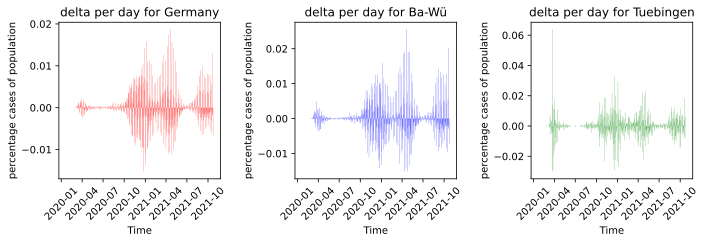

In [ ]:
import matplotlib.dates as mdates

# Plot timeseries
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), sharey=False)
axs[0].bar(germany_deltas['Meldedatum'],germany_deltas["Delta"],color='red')
axs[0].set_title("delta per day for Germany")

axs[1].bar(bawue_deltas['Meldedatum'], bawue_deltas["Delta"],color='blue')
axs[1].set_title("delta per day for Ba-Wü")

axs[2].bar(tuebingen_deltas['Meldedatum'], tuebingen_deltas["Delta"],color='green')
axs[2].set_title("delta per day for Tuebingen")

for ax in axs:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("percentage cases of population")

plt.tight_layout()

Can you make out a trend? : 
We can make out the trend of a fourth wave. However, it currently seems to be smaller than the second and third wave and rather stagnates. The delta seems to depend on the day, probably there are fewer cases reported on the weekends. This can be seen especially for the trend in Tübingen. Baden-Württemberg is quite representative for the german trend.

### Estimating the Basic Reproduction Number $R_0$

Next, we will compute a rough estimate of the _basic reproduction number_ $R_0$ of COVID-19. The reproduction number is used to measure the transmission potential of a disease and constitutes the average number of infections caused by a typical case in a completely susceptible population.

[^1]: https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory

**Task:** Compute and plot a running estimate of the basic reproduction number by computing the ratio between the number of new infections in the last four days and the number of new infections in the four days before that. What can you say about the estimate of the reproduction rate for the current day and over time? If you had to make policy decisions based on this estimate, what would your response be?

*Hint:* To help illustrate your answer to the last two questions, you can use the `datetime` format and `matplotlib` to draw vertical lines on specific dates.

Source $R_0$ estimation: https://www.rki.de/DE/Content/Infekt/EpidBull/Archiv/2020/Ausgaben/17_20.pdf?__blob=publicationFile

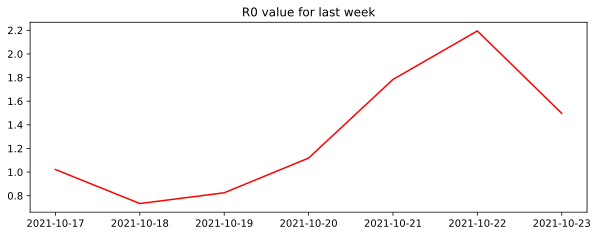

In [61]:
# Create dataframe of number of new cases
data_rki_cases = data_rki.copy()[["Meldedatum", "AnzahlFall"]] # TODO
data_rki_cases["Meldedatum"] = pd.to_datetime(data_rki_cases["Meldedatum"])
data_rki_cases = data_rki_cases.groupby("Meldedatum").sum()

# Compute number of new cases in last four days and in four days prior to that
data_rki_four_days = data_rki_cases.rolling(4).sum()

# Estimate the basic reproduction number R0
r0 = data_rki_four_days.values[7:] / data_rki_four_days.values[3:-4]

# Show data from the previous week
plt.figure(figsize=(10, 3.5))
plt.plot(data_rki_four_days.index[-7:],r0[-7:],color='red')
plt.title('R0 value for last week');

In [66]:
print('R0 mean for the last 7 days: ', r0[-7:].mean())

R0 mean for the last 7 days:  1.310712979374499


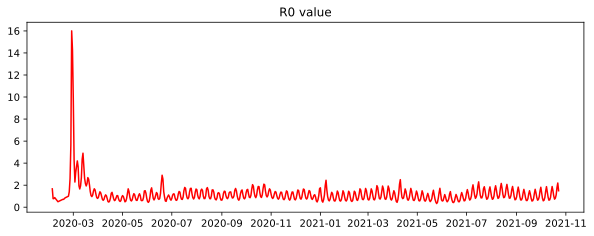

In [69]:
# Plot reproduction rate
plt.figure(figsize=(10, 3.5))
plt.plot(data_rki_four_days.index[7:],r0,color='red')
plt.title('R0 value');

What can you say about the estimate of the reproduction rate for the current day and over time?   
Todays r0 value is lower than yesterdays, however, this can be due to a lower number of reported cases on the weekend. Over the last week the r0 value oscillated a lot, with a mean of 1.3, and seemed to increase throughout the week. In march 2020 the r0 value is extremely high, afterwards it oscillates around 1.

If you had to make policy decisions based on this estimate, what would your response be?  
With the current policies of 3G and 2G we would not enforce additional policies unless the r0 value starts to steadily increase over time.

### Global COVID-19 Data

Next, we will take a look at the global case numbers for the corona virus from [OurWorldInData.org](https://ourworldindata.org/coronavirus-testing).

**Task:** Download the CSV data from the given URL and parse the `date` column into `datetime` format of the form `2021-11-01`. Why is it important to have a dedicated format for dates instead of just a string representation?

In [70]:
# Link to world-wide COVID data
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

# Read CSV data from URL
data_owid = pd.read_csv(url) 

# Parse data
data_owid["date"] = pd.to_datetime(data_owid["date"],format="%Y-%m-%d")

# Inspect dataframe and datatypes
display(data_owid)
display(data_owid.dtypes)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,ZWE,Africa,Zimbabwe,2021-10-19,132405.0,37.0,55.571,4659.0,1.0,2.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125755,ZWE,Africa,Zimbabwe,2021-10-20,132437.0,32.0,47.000,4659.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125756,ZWE,Africa,Zimbabwe,2021-10-21,132540.0,103.0,41.286,4662.0,3.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125757,ZWE,Africa,Zimbabwe,2021-10-22,132588.0,48.0,43.286,4663.0,1.0,1.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


iso_code                                           object
continent                                          object
location                                           object
date                                       datetime64[ns]
total_cases                                       float64
                                                ...      
human_development_index                           float64
excess_mortality_cumulative_absolute              float64
excess_mortality_cumulative                       float64
excess_mortality                                  float64
excess_mortality_cumulative_per_million           float64
Length: 65, dtype: object

Why is it important to have a dedicated format for dates instead of just a string representation?: A dedicated format is easier to work with and supports more features like grouping

**Task:** Subset the world-wide data with the countries of interest and create a new dataframe with seven columns, namely `iso_code`, `date`, `new_cases`, `new_cases_per_million`, `new_cases_smoothed_per_million`, a newly computed `case_fatality_rate` and the `positive_rate`.

*Hint:* The case fatality rate (CFR) is defined as the fraction of deaths and cases.

In [71]:
# Countries of interest (CoIs)
cois = ["DEU", "GBR", "USA", "FRA", "NLD"]
cols = ['iso_code', 'date', 'new_cases', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'cfr', 'positive_rate']

# Subset worldwide data with CoIs
cois_df = pd.DataFrame()

for coi in cois:
    new_coi = data_owid[data_owid["iso_code"] == coi]
    cois_df = pd.concat([cois_df, new_coi])
    
# Create CFR column
cfr = cois_df['total_deaths'] / cois_df['total_cases'] 
cois_df['cfr'] = cfr

# Remove unnecessary columns
cois_df = cois_df.drop(cois_df.columns.difference(cols), 1)

In [82]:
cois_df

,iso_code,date,new_cases,new_cases_per_million,new_cases_smoothed_per_million,positive_rate,cfr
43282,DEU,2020-01-27,1.0,0.012,NaN,NaN,NaN
43283,DEU,2020-01-28,3.0,0.036,NaN,NaN,NaN
43284,DEU,2020-01-29,0.0,0.000,NaN,NaN,NaN
43285,DEU,2020-01-30,0.0,0.000,NaN,NaN,NaN
43286,DEU,2020-01-31,1.0,0.012,NaN,NaN,NaN
...,...,...,...,...,...,...,...
80290,NLD,2021-10-19,3948.0,229.895,216.177,NaN,0.008927
80291,NLD,2021-10-20,4633.0,269.782,223.339,NaN,0.008913
80292,NLD,2021-10-21,5230.0,304.546,236.117,NaN,0.008895
80293,NLD,2021-10-22,5903.0,343.735,254.110,NaN,0.008874


### Pandemic Severity across Countries

**Task:** From the world-wide data generate timeseries plots showing new cases per million inhabitants (both raw and smoothed), the computed case fatality rate, and the rate of positive tests. Use log-axes where appropriate and make sure your plots are legible and have properly formatted dates! 
 
How do you explain the falling case fatality rate and the increasing positive rate over time? Which country fares the best in terms of the pandemic, which the worst?

In [88]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3.5), sharey=False)

# Plotting colors
colors = dict(zip(cois, ["C0", "C1", "C2", "C3", "C4"]))

for coi in cois:
    
    # New Cases:
    coi_data = cois_df[cois_df['iso_code']==coi]
    axs[0].bar(coi_data["date"], coi_data["new_cases_per_million"],color=colors[coi], alpha=0.5)
    axs[0].set_title("new_cases_per_million")
    axs[0].legend(cois)
    axs[0].set_ylim(0, 1500)

    coi_data = cois_df[cois_df['iso_code']==coi]
    axs[1].bar(coi_data["date"], coi_data["new_cases_smoothed_per_million"],color=colors[coi], alpha=0.5)
    axs[1].set_title("new_cases_smoothed_per_million")
    axs[1].set_ylim(0, 1500)
    
    # Case fatality rate
    coi_data = cois_df[cois_df['iso_code']==coi]
    axs[2].bar(coi_data["date"], coi_data["cfr"],color=colors[coi], alpha=0.5)
    axs[2].set_title("cfr")
    
    # Rate of positive tests
    coi_data = cois_df[cois_df['iso_code']==coi]
    axs[3].bar(coi_data["date"], coi_data["positive_rate"],color=colors[coi], alpha=0.5)
    axs[3].set_title("positive_rate")
    
# Date formatting
for ax in axs:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Time")

plt.tight_layout()


How do you explain the falling case fatality rate and the increasing positive rate over time?  
The falling case fatality rate can be due to lockdowns and vaccines. The positive rate seems to correlate with the covid waves.

Which country fares the best in terms of the pandemic, which the worst?  
GBR, NDL and FRA had a high case fatality rate at the beginning of the pandemic, but successfully enforced policies to reduce it. Now the cfr is similar over all 5 countries.
Currently, GBR has a high and increasing number of new cases, USA seems to decrease and DEU is starting to increase its number of new cases again.